<a href="https://colab.research.google.com/github/KAFE45/Colab-LabBCI/blob/main/KAFE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mne pyxdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 23.8 MB/s eta 0:00:00


In [ ]:
import pyxdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from google.colab import files
import io
from scipy.fft import fft

In [ ]:
# Upload file
uploaded = files.upload()

# Select uploaded file
file_name = list(uploaded.keys())[0]

Saving sub-DataSSVEP551_ses-S002_task-Default_run-001_eeg.xdf to sub-DataSSVEP551_ses-S002_task-Default_run-001_eeg.xdf


In [11]:
# ฟังก์ชันสำหรับโหลดข้อมูลจากไฟล์ .xdf
def load_data(filepath):
    streams, header = pyxdf.load_xdf(filepath)

    eeg_stream = None
    marker_stream = None
    for stream in streams:
        if stream['info']['name'][0] == 'eeg' and stream['info']['type'][0] == 'signal':
            eeg_stream = stream
        elif stream['info']['type'][0] == 'Markers':
            marker_stream = stream

    if eeg_stream is None:
        raise ValueError(f"ไม่พบ stream ชื่อ 'eeg' ในไฟล์ {filepath}")

    data = eeg_stream['time_series']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    channel_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']
    channel_labels = [chan['label'][0] for chan in channel_names]

    df = pd.DataFrame(data, columns=channel_labels)

    markers = []
    if marker_stream:
        marker_times = marker_stream['time_stamps']
        marker_values = marker_stream['time_series']
        markers = list(zip(marker_times, marker_values))

    return df, sampling_rate, markers

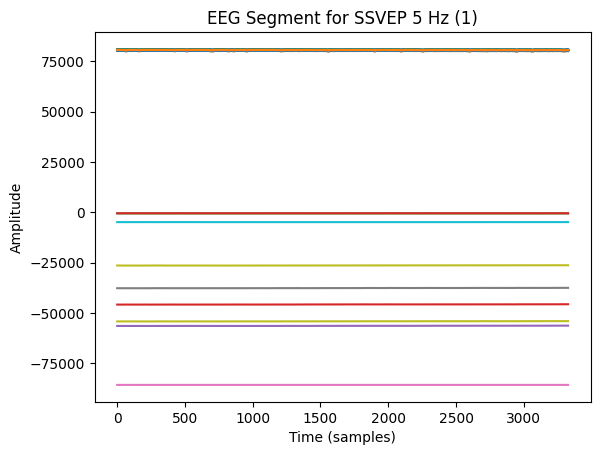

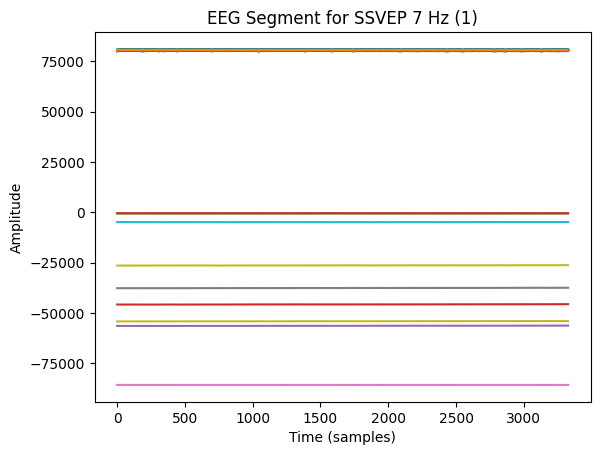

In [12]:

# โหลดข้อมูลจากไฟล์ XDF
streams, header = pyxdf.load_xdf('/content/sub-DataSSVEP551_ses-S002_task-Default_run-001_eeg.xdf')
# สมมุติให้ eeg_stream และ marker_stream ชื่อของสตรีมที่ใช้
eeg_stream = [s for s in streams if s['info']['name'][0] == 'eeg'][0]
marker_stream = [s for s in streams if s['info']['name'][0] == 'PsychoPyMarkers'][0]

# รับข้อมูลสัญญาณ EEG และมาร์กเกอร์
eeg_data = eeg_stream['time_series']
markers = marker_stream['time_series']

# กำหนดมาร์กเกอร์เริ่มต้นและสิ้นสุดสำหรับ SSVEP
ssvep_5hz_trigger_start = 2  # Start trigger for SSVEP 5 Hz
ssvep_5hz_trigger_end = 12    # End trigger for SSVEP 5 Hz
ssvep_7hz_trigger_start = 4   # Start trigger for SSVEP 7 Hz
ssvep_7hz_trigger_end = 14     # End trigger for SSVEP 7 Hz

# ฟังก์ชันในการตัดสัญญาณ
def cut_ssvep_signal(eeg_data, markers, start_trigger, end_trigger, pre_time=1, post_time=2, fs=256):
    segments = []
    for i in range(len(markers) - 1):
        if markers[i][0] == start_trigger and markers[i + 1][0] == end_trigger:
            start = int((markers[i][0] - pre_time) * fs)  # คำนวณเวลาเริ่มต้น
            end = int((markers[i + 1][0] + post_time) * fs)  # คำนวณเวลาสิ้นสุด
            segment = eeg_data[start:end]  # ตัดสัญญาณ
            segments.append(segment)
    return segments

# ตัดสัญญาณ EEG สำหรับ SSVEP 5 Hz
eeg_segments_5hz = cut_ssvep_signal(eeg_data, markers, ssvep_5hz_trigger_start, ssvep_5hz_trigger_end)

# ตัดสัญญาณ EEG สำหรับ SSVEP 7 Hz
eeg_segments_7hz = cut_ssvep_signal(eeg_data, markers, ssvep_7hz_trigger_start, ssvep_7hz_trigger_end)

# แสดงผล
for i, segment in enumerate(eeg_segments_5hz):
    plt.figure()
    plt.plot(segment)
    plt.title(f'EEG Segment for SSVEP 5 Hz ({i + 1})')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.show()

for i, segment in enumerate(eeg_segments_7hz):
    plt.figure()
    plt.plot(segment)
    plt.title(f'EEG Segment for SSVEP 7 Hz ({i + 1})')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.show()


In [ ]:
# Bandpass filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

    # Plot power spectrum
def plot_power_spectrum(df, sampling_rate, markers, channels, title_prefix, color='blue', target_freqs=[5, 7], bandwidth=2):
    plt.figure(figsize=(15, 20))

    for i, channel in enumerate(channels):
        if channel in df.columns:
            signal = df[channel].values
            filtered_signal = bandpass_filter(signal, 1, 50, sampling_rate)

            N = len(filtered_signal)
            T = 1.0 / sampling_rate
            yf = fft(filtered_signal)
            xf = np.fft.fftfreq(N, T)[:N // 2]
            power_spectrum = 2.0 / N * np.abs(yf[:N // 2])

            plt.subplot(len(channels), 1, i + 1)
            plt.plot(xf, power_spectrum, color=color, label=f'{title_prefix} {channel}')
            plt.title(f'Power Spectrum for {channel}')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power')
            plt.grid()
            plt.xlim(0, 10)
            plt.xticks(np.arange(1, 11, 1))

            for target_freq in target_freqs:
                plt.axvspan(target_freq - bandwidth, target_freq + bandwidth, color='orange', alpha=0.3, label=f'Target: {target_freq} Hz ±{bandwidth} Hz')

            plt.legend()
        else:
            print(f'Warning: {channel} not found in data columns.')

    plt.tight_layout()
    plt.show()

# แสดงผล

for i, segment in enumerate(eeg_segments):
  # Plot power spectrum for each selected segment
channels = ['O1', 'Fz', 'O2', 'Cz', 'Pz']
plot_power_spectrum(df1, sampling_rate1, markers1, channels, 'File 1', color='blue', target_freqs=[5, 7], bandwidth=2)
    plt.figure()
    plt.plot(segment)
    plt.title(f'EEG Segment for SSVEP {5 + 2*i} Hz')  # เปลี่ยนชื่อเป็น 5 Hz และ 7 Hz
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.show()

In [ ]:
# สมมุติให้ eeg_stream และ marker_stream ชื่อของสตรีมที่ใช้
eeg_stream = [s for s in streams if s['info']['name'][0] == 'eeg'][0]
marker_stream = [s for s in streams if s['info']['name'][0] == 'PsychoPyMarkers'][0]

# รับข้อมูลสัญญาณ EEG และมาร์กเกอร์
eeg_data = eeg_stream['time_series']
markers = marker_stream['time_series']

# กำหนดมาร์กเกอร์ที่ใช้สำหรับ SSVEP
ssvep_5hz_trigger_start = 2  # Start trigger for SSVEP 5 Hz
ssvep_5hz_trigger_end = 12    # End trigger for SSVEP 5 Hz
ssvep_7hz_trigger_start = 4   # Start trigger for SSVEP 7 Hz
ssvep_7hz_trigger_end = 14     # End trigger for SSVEP 7 Hz

# ฟังก์ชันในการตัดสัญญาณตามมาร์กเกอร์
def cut_ssvep_segments(eeg_data, markers, start_triggers, end_triggers, pre_time=1, post_time=2, fs=256):
    segments = []
    for marker in markers:
        # ตรวจสอบการจับคู่กับมาร์กเกอร์ที่เริ่มต้นและสิ้นสุด
        if marker[0] in start_triggers:
            start_idx = int((marker[0] - pre_time) * fs)  # คำนวณเวลาเริ่มต้น
            end_idx = int((end_triggers[start_triggers.index(marker[0])] + post_time) * fs)  # คำนวณเวลาสิ้นสุด
            segment = eeg_data[start_idx:end_idx]  # ตัดสัญญาณ
            segments.append(segment)
    return segments

# กำหนดลิสต์สำหรับการจับคู่มาร์กเกอร์เริ่มต้นและสิ้นสุด
start_triggers = [ssvep_5hz_trigger_start, ssvep_7hz_trigger_start]
end_triggers = [ssvep_5hz_trigger_end, ssvep_7hz_trigger_end]

# ตัดสัญญาณ EEG ตามมาร์กเกอร์
eeg_segments = cut_ssvep_segments(eeg_data, markers, start_triggers, end_triggers)

# Bandpass filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    if len(data) <= 33:  # Check if data length is appropriate for filtering
        return data  # Skip filtering for too-short data
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Plot power spectrum
def plot_power_spectrum(signal, sampling_rate, title_prefix, color='blue', target_freqs=[5, 7], bandwidth=2):
    N = len(signal)
    T = 1.0 / sampling_rate
    yf = fft(signal)
    xf = np.fft.fftfreq(N, T)[:N // 2]
    power_spectrum = 2.0 / N * np.abs(yf[:N // 2])

    plt.figure(figsize=(15, 5))
    plt.plot(xf, power_spectrum, color=color, label=f'{title_prefix}')
    plt.title(f'Power Spectrum for {title_prefix}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.grid()
    plt.xlim(0, 10)
    plt.xticks(np.arange(1, 11, 1))

    for target_freq in target_freqs:
        plt.axvspan(target_freq - bandwidth, target_freq + bandwidth, color='orange', alpha=0.3, label=f'Target: {target_freq} Hz ±{bandwidth} Hz')

    plt.legend()
    plt.show()

# Bandpass filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    if len(data) <= 100:  # Increased length requirement for filtering
        print(f"Segment too short for filtering: {len(data)} samples.")
        return data  # Return original data if too short
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# แสดงผล
channels = ['O1', 'Fz', 'O2', 'Cz', 'Pz']
sampling_rate = 256  # Adjust if necessary

for i, segment in enumerate(eeg_segments):
    print(f"Processing segment {i} with length: {len(segment)} samples.")  # Debugging information
    if len(segment) > 100:  # Ensure segment is longer than the filter's pad length
        filtered_segment = bandpass_filter(segment, 1, 50, sampling_rate)
        plot_power_spectrum(filtered_segment, sampling_rate, f'SSVEP Segment {5 + 2*i} Hz', color='blue', target_freqs=[5, 7], bandwidth=2)

        plt.figure()
        plt.plot(segment)
        plt.title(f'EEG Segment for SSVEP {5 + 2*i} Hz')  # เปลี่ยนชื่อเป็น 5 Hz และ 7 Hz
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude')
        plt.show()
    else:
        print(f'Segment {i} is too short for filtering: {len(segment)} samples.')



Processing segment 0 with length: 3328 samples.


ValueError: The length of the input vector x must be greater than padlen, which is 33.

In [ ]:
# ฟังก์ชันสำหรับตัดสัญญาณ EEG รอบๆ มาร์กเกอร์ที่เลือก
def cut_signal_for_selected_markers(df, sampling_rate, markers, selected_markers, pre_marker_sec=1, post_marker_sec=2):
    cut_segments = []
    for timestamp, marker in markers:
        marker_value = marker[0]

        # ตรวจสอบว่าค่ามาร์กเกอร์อยู่ในรายการมาร์กเกอร์ที่ต้องการหรือไม่
        if marker_value in selected_markers:
            # คำนวณตำแหน่งเริ่มต้นและสิ้นสุดสำหรับช่วงสัญญาณ
            start_idx = int((timestamp - pre_marker_sec) * sampling_rate)
            end_idx = int((timestamp + post_marker_sec) * sampling_rate)

            # ตรวจสอบว่าตำแหน่งอยู่ภายในขอบเขตข้อมูล
            if start_idx >= 0 and end_idx <= len(df):
                segment = df.iloc[start_idx:end_idx]  # ตัดสัญญาณช่วงที่สนใจ
                cut_segments.append((segment, marker_value))

    return cut_segments

In [ ]:
# Show markers
print("Markers from File 1:")
for timestamp, marker in markers1:
    print(f"Timestamp: {timestamp:.2f}, Marker: {marker[0]}")

In [ ]:
# Function for cutting EEG signal around specific markers
def cut_signal_for_selected_markers(df, sampling_rate, markers, selected_markers, pre_marker_sec=1, post_marker_sec=2):
    cut_segments = []
    for timestamp, marker in markers:
        marker_value = marker[0]

        # Check if the marker is in the selected markers list
        if marker_value in selected_markers:
            start_idx = int((timestamp - pre_marker_sec) * sampling_rate)
            end_idx = int((timestamp + post_marker_sec) * sampling_rate)

            # Check that the indices are within bounds
            if start_idx >= 0 and end_idx <= len(df):
                segment = df.iloc[start_idx:end_idx]
                cut_segments.append((segment, marker_value))

    return cut_segments

In [ ]:
# Define selected markers (2, 12, 4, 14)
selected_markers = [2, 12, 4, 14]
print(selected_markers)

In [ ]:
# Load data
df1, sampling_rate1, markers1 = load_data(io.BytesIO(uploaded[file_name]))
print(df1, sampling_rate1, markers1)

In [ ]:
# Cut segments for the selected markers
cut_segments_selected = cut_signal_for_selected_markers(df1, sampling_rate1, markers1, selected_markers)

print(f"จำนวน segment ที่ถูกตัด: {len(cut_segments_selected)}")

In [ ]:
# Bandpass filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [ ]:
# Plot power spectrum
def plot_power_spectrum(df, sampling_rate, markers, channels, title_prefix, color='blue', target_freqs=[5, 7], bandwidth=2):
    plt.figure(figsize=(15, 20))

    for i, channel in enumerate(channels):
        if channel in df.columns:
            signal = df[channel].values
            filtered_signal = bandpass_filter(signal, 1, 50, sampling_rate)

            N = len(filtered_signal)
            T = 1.0 / sampling_rate
            yf = fft(filtered_signal)
            xf = np.fft.fftfreq(N, T)[:N // 2]
            power_spectrum = 2.0 / N * np.abs(yf[:N // 2])

            plt.subplot(len(channels), 1, i + 1)
            plt.plot(xf, power_spectrum, color=color, label=f'{title_prefix} {channel}')
            plt.title(f'Power Spectrum for {channel}')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power')
            plt.grid()
            plt.xlim(0, 10)
            plt.xticks(np.arange(1, 11, 1))

            for target_freq in target_freqs:
                plt.axvspan(target_freq - bandwidth, target_freq + bandwidth, color='orange', alpha=0.3, label=f'Target: {target_freq} Hz ±{bandwidth} Hz')

            plt.legend()
        else:
            print(f'Warning: {channel} not found in data columns.')

    plt.tight_layout()
    plt.show()

In [ ]:
# Plot power spectrum for each selected segment
channels = ['O1', 'Fz', 'O2', 'Cz', 'Pz']
plot_power_spectrum(df1, sampling_rate1, markers1, channels, 'File 1', color='blue', target_freqs=[5, 7], bandwidth=2)